In [464]:
# ---- Import Libraries ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
import shap
import rasterio
from rasterio.transform import Affine
from rasterio.crs import CRS
import os

sns.set(style="whitegrid")

In [465]:
# ---- Config ----
CSV_PATH = 'bentre2020.csv'
target = 'Ece'
features = ['Sand', 'Clay', 'Bulk', 'LSTModis', 'SM', 'SR', 'SI1','SI2','SI3','SI4','SI5','DEM','NDSI','NDVI','DEM','SWIR1','SWIR2','LULC']
random_state = 42

In [466]:
# ---- Load & Clean ----
df = pd.read_csv(CSV_PATH)
df = df.loc[~(df[features] == -9999).any(axis=1)].copy()
df = df[~df[target].isna()]  # Thêm dòng này để loại bỏ NaN ở target
df = df.reset_index().rename(columns={'index': 'sample_id'})  

X = df[features].values
y = df[target].values
sample_ids = df['sample_id'].values

In [467]:
# ---- Metrics helper ----
def rmse(a, b): return np.sqrt(mean_squared_error(a, b))
def mae(a, b): return mean_absolute_error(a, b)
def pearson_r(a, b):
    if len(a) < 2: return np.nan
    return np.corrcoef(a, b)[0, 1]


In [468]:
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features='sqrt',
    max_samples=0.85,
    oob_score=True,
    random_state=random_state,
    n_jobs=-1
)


In [469]:
# ---- K-Fold Cross-Validation ----
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

train_r2_scores, train_rmse_scores, train_mae_scores = [], [], []
test_r2_scores, test_rmse_scores, test_mae_scores = [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f"\n--- Fold {fold} ---")
    
    # Split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train
    rf.fit(X_train, y_train)

    # Predict
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)

    # Metrics
    R_train = pearson_r(y_train, y_train_pred)
    RMSE_train = rmse(y_train, y_train_pred)
    MAE_train = mae(y_train, y_train_pred)

    R_test = pearson_r(y_test, y_test_pred)
    RMSE_test = rmse(y_test, y_test_pred)
    MAE_test = mae(y_test, y_test_pred)

    # Save fold results
    train_r2_scores.append(R_train); train_rmse_scores.append(RMSE_train); train_mae_scores.append(MAE_train)
    test_r2_scores.append(R_test); test_rmse_scores.append(RMSE_test); test_mae_scores.append(MAE_test)

    # Print fold results
    print(f"Training Set: R={R_train:.4f}, RMSE={RMSE_train:.4f}, MAE={MAE_train:.4f}")
    print(f"Testing Set : R={R_test:.4f}, RMSE={RMSE_test:.4f}, MAE={MAE_test:.4f}")

# Print summary after all folds
print("\n--- Summary ---")
print("Training Set:")
print(f"R: {np.mean(train_r2_scores):.4f} ± {np.std(train_r2_scores):.4f}")
print(f"RMSE: {np.mean(train_rmse_scores):.4f} ± {np.std(train_rmse_scores):.4f}")
print(f"MAE: {np.mean(train_mae_scores):.4f} ± {np.std(train_mae_scores):.4f}")

print("\nTesting Set:")
print(f"R: {np.mean(test_r2_scores):.4f} ± {np.std(test_r2_scores):.4f}")
print(f"RMSE: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")
print(f"MAE: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")


--- Fold 1 ---
Training Set: R=0.8160, RMSE=3.5213, MAE=2.2398
Testing Set : R=0.7859, RMSE=3.8942, MAE=2.6632

--- Fold 2 ---
Training Set: R=0.8384, RMSE=3.1983, MAE=2.1223
Testing Set : R=0.6472, RMSE=5.2560, MAE=3.2014

--- Fold 3 ---
Training Set: R=0.8302, RMSE=3.5589, MAE=2.3515
Testing Set : R=0.7287, RMSE=3.3707, MAE=1.7462

--- Fold 4 ---
Training Set: R=0.8329, RMSE=3.5310, MAE=2.1863
Testing Set : R=0.6582, RMSE=3.8137, MAE=2.9402

--- Fold 5 ---
Training Set: R=0.8377, RMSE=3.3076, MAE=2.0889
Testing Set : R=0.7102, RMSE=4.5894, MAE=3.2432

--- Summary ---
Training Set:
R: 0.8310 ± 0.0081
RMSE: 3.4234 ± 0.1439
MAE: 2.1978 ± 0.0928

Testing Set:
R: 0.7060 ± 0.0503
RMSE: 4.1848 ± 0.6627
MAE: 2.7588 ± 0.5473


Số điểm tốt nhất: 35
Số điểm xấu nhất: 35


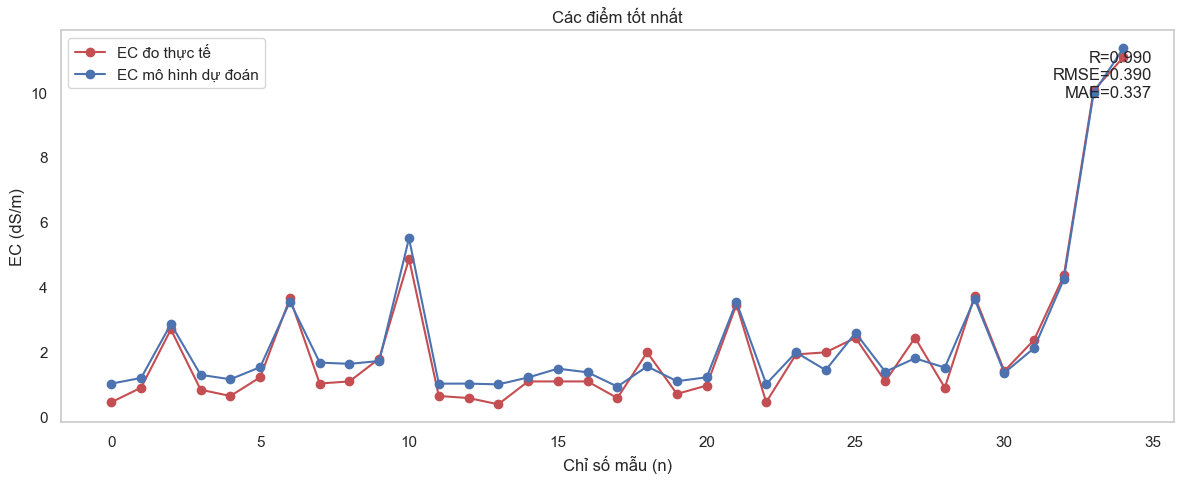

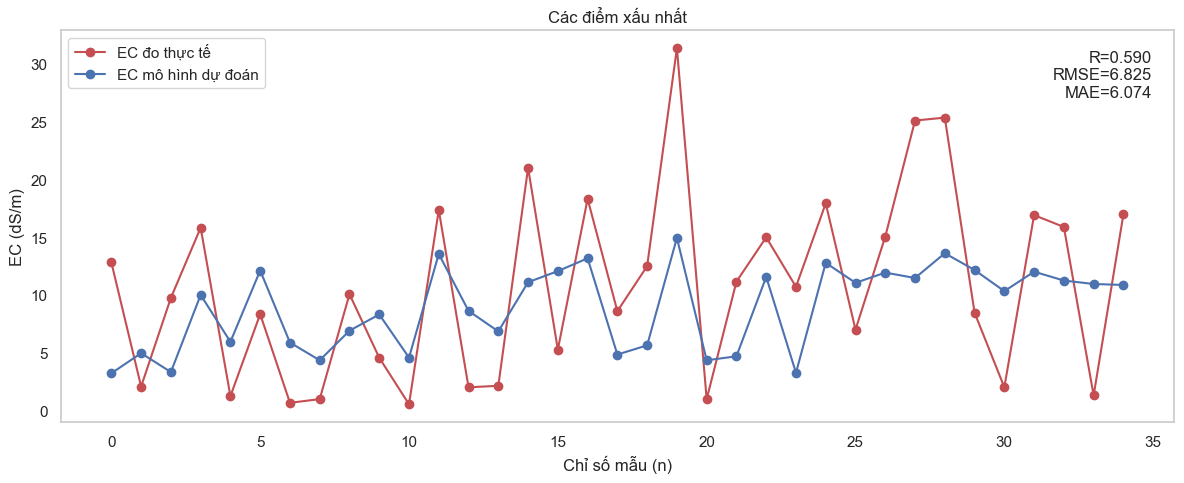


===== THỐNG KÊ LULC TẠI CÁC ĐIỂM XẤU NHẤT =====
LULC
9      6
11     8
14     3
17    18
Name: count, dtype: int64


C:\Users\Quang\AppData\Local\Temp\ipykernel_10668\2238470740.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_points["LULC"] = df.loc[bad_points.index, "LULC"].astype(int)   # ⭐ Ép kiểu int cho LULC


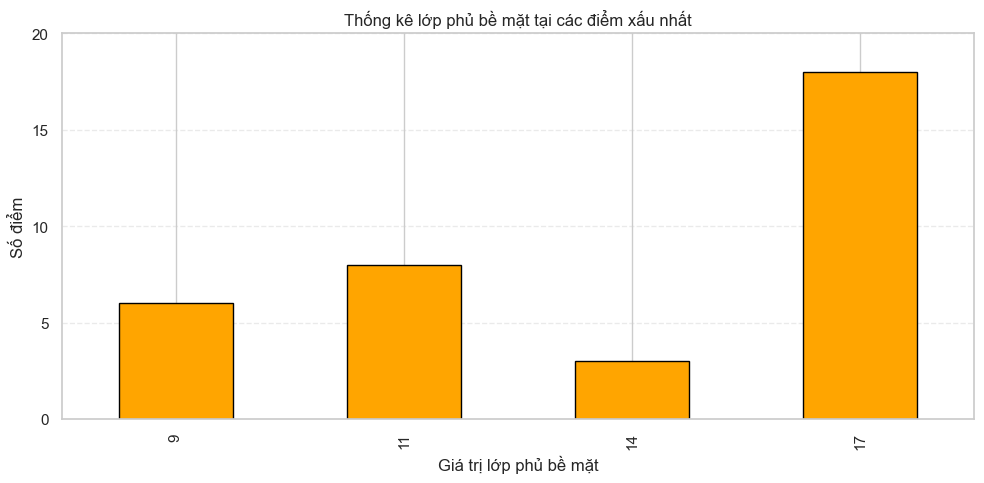

In [470]:
# ======================================================
# PHÂN LOẠI ĐIỂM TỐT / XẤU THEO PHÂN VỊ SAU KHI DỰ ĐOÁN
# ======================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

# 1) Dự đoán toàn bộ dữ liệu
y_pred_full = rf.predict(X)

df_eval = pd.DataFrame({
    "y_true": y,
    "y_pred": y_pred_full
})

# 2) Tính sai số
df_eval["abs_error"] = np.abs(df_eval["y_true"] - df_eval["y_pred"])

# 3) Ngưỡng phân vị
p25 = np.percentile(df_eval["abs_error"], 25)
p75 = np.percentile(df_eval["abs_error"], 75)

# 4) Lọc nhóm tốt và nhóm xấu
good_points = df_eval[df_eval["abs_error"] <= p25]
bad_points  = df_eval[df_eval["abs_error"] >= p75]

print(f"Số điểm tốt nhất: {len(good_points)}")
print(f"Số điểm xấu nhất: {len(bad_points)}")

# 5) Hàm tính R, RMSE, MAE
def evaluate(group):
    R = pearsonr(group["y_true"], group["y_pred"])[0]
    RMSE = np.sqrt(mean_squared_error(group["y_true"], group["y_pred"]))   # KHÔNG dùng squared=False
    MAE = mean_absolute_error(group["y_true"], group["y_pred"])
    return R, RMSE, MAE

R_good, RMSE_good, MAE_good = evaluate(good_points)
R_bad , RMSE_bad , MAE_bad  = evaluate(bad_points)

# ======================================================
# 6) VẼ BIỂU ĐỒ — NHÓM TỐT NHẤT
# ======================================================
plt.figure(figsize=(12,5))
plt.plot(good_points["y_true"].values, 'r-o', label="EC đo thực tế")
plt.plot(good_points["y_pred"].values, 'b-o', label="EC mô hình dự đoán")

plt.title(f"Các điểm tốt nhất")
plt.xlabel("Chỉ số mẫu (n)")
plt.ylabel("EC (dS/m)")
plt.legend()
plt.grid(False)

plt.text(
    0.98, 0.95,
    f"R={R_good:.3f}\nRMSE={RMSE_good:.3f}\nMAE={MAE_good:.3f}",
    transform=plt.gca().transAxes,
    ha="right", va="top"
)
plt.tight_layout()
plt.show()


# ======================================================
# 7) VẼ BIỂU ĐỒ — NHÓM XẤU NHẤT
# ======================================================
plt.figure(figsize=(12,5))
plt.plot(bad_points["y_true"].values, 'r-o', label="EC đo thực tế")
plt.plot(bad_points["y_pred"].values, 'b-o', label="EC mô hình dự đoán")

plt.title(f"Các điểm xấu nhất")
plt.xlabel("Chỉ số mẫu (n)")
plt.ylabel("EC (dS/m)")
plt.legend()
plt.grid(False)

plt.text(
    0.98, 0.95,
    f"R={R_bad:.3f}\nRMSE={RMSE_bad:.3f}\nMAE={MAE_bad:.3f}",
    transform=plt.gca().transAxes,
    ha="right", va="top"
)
plt.tight_layout()
plt.show()


if "LULC" in df.columns:

    bad_points["LULC"] = df.loc[bad_points.index, "LULC"].astype(int)   # ⭐ Ép kiểu int cho LULC

    # Thống kê số lượng
    lulc_counts = bad_points["LULC"].value_counts().sort_index()
    print("\n===== THỐNG KÊ LULC TẠI CÁC ĐIỂM XẤU NHẤT =====")
    print(lulc_counts)

plt.figure(figsize=(10,5))
lulc_counts.plot(kind="bar", color="orange", edgecolor="black")

plt.title("Thống kê lớp phủ bề mặt tại các điểm xấu nhất")
plt.xlabel("Giá trị lớp phủ bề mặt")
plt.ylabel("Số điểm")

# ⭐ Trục Y nhảy theo đơn vị 5
plt.yticks(range(0, lulc_counts.max()+5, 5))

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()




C:\Users\Quang\AppData\Local\Temp\ipykernel_10668\2318028718.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


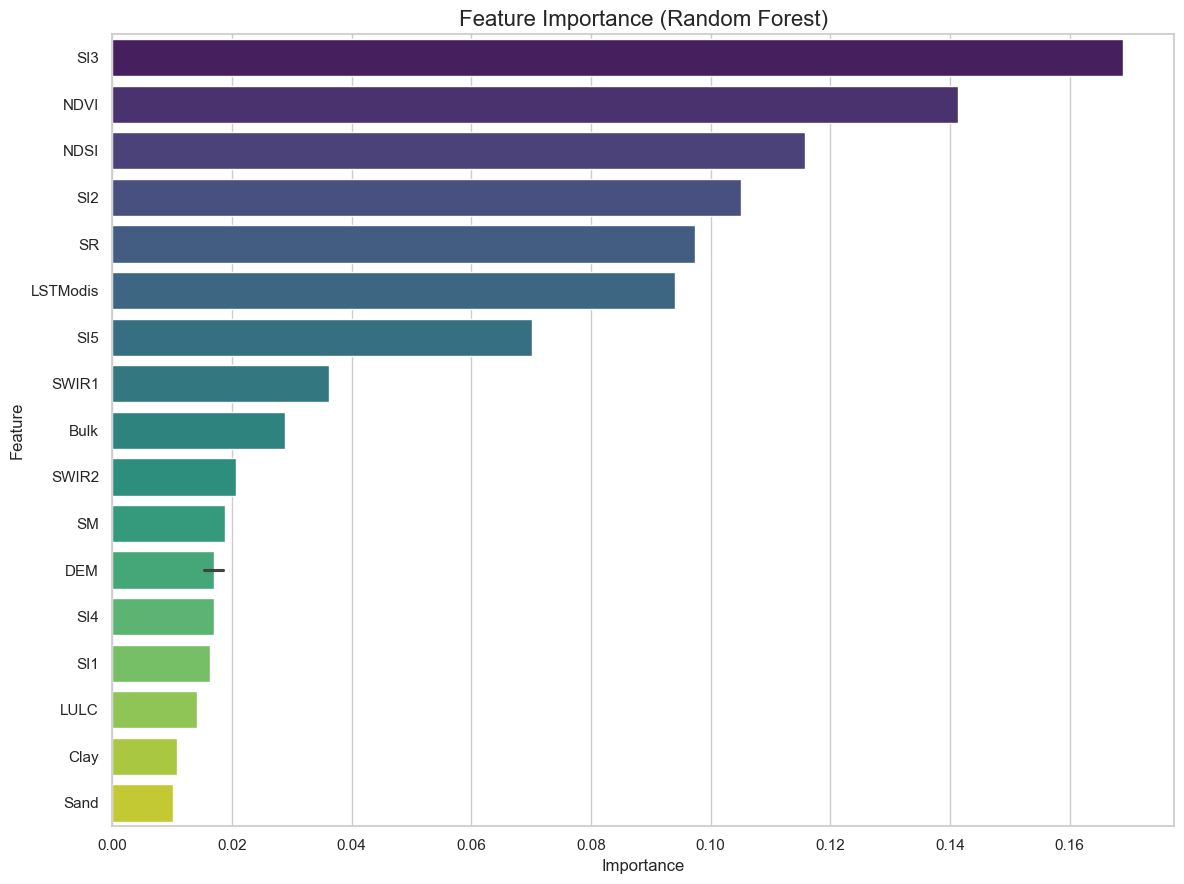

In [471]:
# ---- Feature Importance ----
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, len(features) * 0.5))  # Tăng chiều cao để hiển thị đầy đủ
sns.barplot(
    x=importances[indices], 
    y=np.array(features)[indices], 
    palette="viridis", 
    orient="h"  # Sắp xếp theo chiều ngang
)
plt.title("Feature Importance (Random Forest)", fontsize=16)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

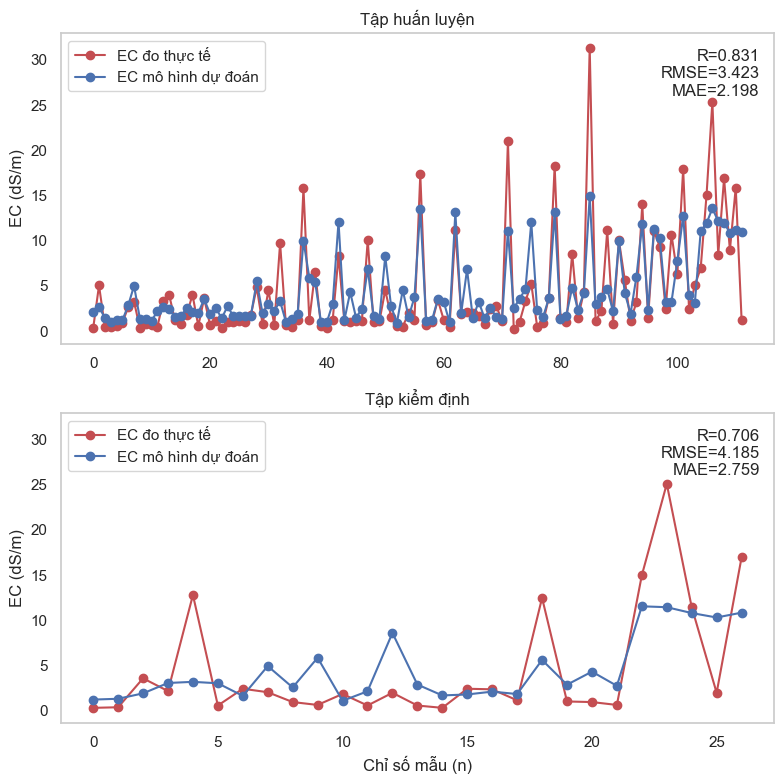

In [472]:
# ---- Prediction Plots ----
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharey=True)

axes[0].grid(False)
axes[1].grid(False)

# -----------------------------------------------
# 1) Tập huấn luyện
# -----------------------------------------------
axes[0].plot(range(len(y_train)), y_train, 'r-o', label="EC đo thực tế")
axes[0].plot(range(len(y_train)), y_train_pred, 'b-o', label="EC mô hình dự đoán")
axes[0].set_title("Tập huấn luyện")
axes[0].set_ylabel("EC (dS/m)")
axes[0].legend()

axes[0].text(
    0.98, 0.95,
    f"R={np.mean(train_r2_scores):.3f}\nRMSE={np.mean(train_rmse_scores):.3f}\nMAE={np.mean(train_mae_scores):.3f}",
    transform=axes[0].transAxes,
    ha="right", va="top"
)

# -----------------------------------------------
# 2) Tập kiểm định
# -----------------------------------------------
axes[1].plot(range(len(y_test)), y_test, 'r-o', label="EC đo thực tế")
axes[1].plot(range(len(y_test)), y_test_pred, 'b-o', label="EC mô hình dự đoán")
axes[1].set_title("Tập kiểm định")
axes[1].set_xlabel("Chỉ số mẫu (n)")
axes[1].set_ylabel("EC (dS/m)")
axes[1].legend()

axes[1].text(
    0.98, 0.95,
    f"R={np.mean(test_r2_scores):.3f}\nRMSE={np.mean(test_rmse_scores):.3f}\nMAE={np.mean(test_mae_scores):.3f}",
    transform=axes[1].transAxes,
    ha="right", va="top"
)

axes[1].set_xticks(np.arange(0, len(y_test)+1, 5))

plt.tight_layout()
plt.show()


In [473]:
# ---- Load Raster Libraries ----
import rasterio
from rasterio.transform import Affine
from rasterio.crs import CRS
from rasterio.warp import reproject, Resampling
import geopandas as gpd
from shapely.geometry import Point
import os
from pathlib import Path

In [474]:
# ---- Load All Raster Data ----
data_folder = r'C:\data\DA\BT\DATA 2020\NEW'

raster_files = {
    'Sand': 'Sand.tif',
    'Clay': 'Clay.tif', 
    'Bulk': 'Bulk.tif',
    'LSTModis': 'LST.tif',
    'SM': 'SM.tif',
    'SR': 'SR.tif',
    'NDSI': 'NDSI.tif',
    'NDVI': 'NDVI.tif',
    'DEM': 'DEM.tif',
    'LULC': 'LULC.tif',
    'SI1': 'SI1.tif',
    'SI2': 'SI2.tif',
    'SI3': 'SI3.tif',
    'SI4': 'SI4.tif',
    'SI5': 'SI5.tif',
    'SWIR1': 'SWIR1.tif',
    'SWIR2': 'SWIR2.tif',
    'LULC': 'LULC.tif'
}

raster_data = {}
for var_name, filename in raster_files.items():
    filepath = os.path.join(data_folder, filename)
    with rasterio.open(filepath) as src:
        raster_data[var_name] = src.read(1)

with rasterio.open(os.path.join(data_folder, 'SR.tif')) as ref_src:
    reference_transform = ref_src.transform
    reference_crs = ref_src.crs
    reference_shape = ref_src.shape
    reference_bounds = ref_src.bounds

In [475]:
# ---- Prepare Data for Prediction ----
# Find minimum dimensions to ensure all rasters match
min_rows = min([data.shape[0] for data in raster_data.values()])
min_cols = min([data.shape[1] for data in raster_data.values()])

# Crop all rasters to same size
prediction_features = []
for feature_name in features:
    raster_cropped = raster_data[feature_name][:min_rows, :min_cols]
    raster_flattened = raster_cropped.flatten()
    prediction_features.append(raster_flattened)

# Stack features
X_prediction = np.column_stack(prediction_features)

# Create valid data mask (remove nodata values)
valid_mask = ~np.any((X_prediction == -9999) | np.isnan(X_prediction), axis=1)

# Update reference shape
reference_shape = (min_rows, min_cols)

In [476]:
# ---- Train Final Model ----
df_clean = pd.read_csv(CSV_PATH)
df_clean = df_clean.loc[~(df_clean[features] == -9999).any(axis=1)].copy()
df_clean = df_clean[~df_clean[target].isna()]  # Loại bỏ NaN ở target

X_train_final = df_clean[features].values
y_train_final = df_clean[target].values

# Train final model
final_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=5,
    max_features='sqrt',
    max_samples=0.85,
    oob_score=True,
    random_state=random_state,
    n_jobs=-1
)

final_model.fit(X_train_final, y_train_final)

RandomForestRegressor(max_depth=12, max_features='sqrt', max_samples=0.85,
                      min_samples_leaf=5, min_samples_split=5, n_estimators=500,
                      n_jobs=-1, oob_score=True, random_state=42)

In [477]:
# ---- Make Spatial Predictions ----
# Initialize prediction array
predictions = np.full(len(X_prediction), np.nan)

# Make predictions only for valid pixels
if np.sum(valid_mask) > 0:
    X_valid = X_prediction[valid_mask]
    predictions_valid = final_model.predict(X_valid)
    predictions[valid_mask] = predictions_valid

# Reshape back to raster grid
prediction_raster = predictions.reshape(reference_shape)

In [478]:
# ---- Create Coordinate Grid ----
rows, cols = reference_shape
x_coords = []
y_coords = []

for row in range(rows):
    for col in range(cols):
        x, y = rasterio.transform.xy(reference_transform, row, col)
        x_coords.append(x)
        y_coords.append(y)

x_coords = np.array(x_coords)
y_coords = np.array(y_coords)

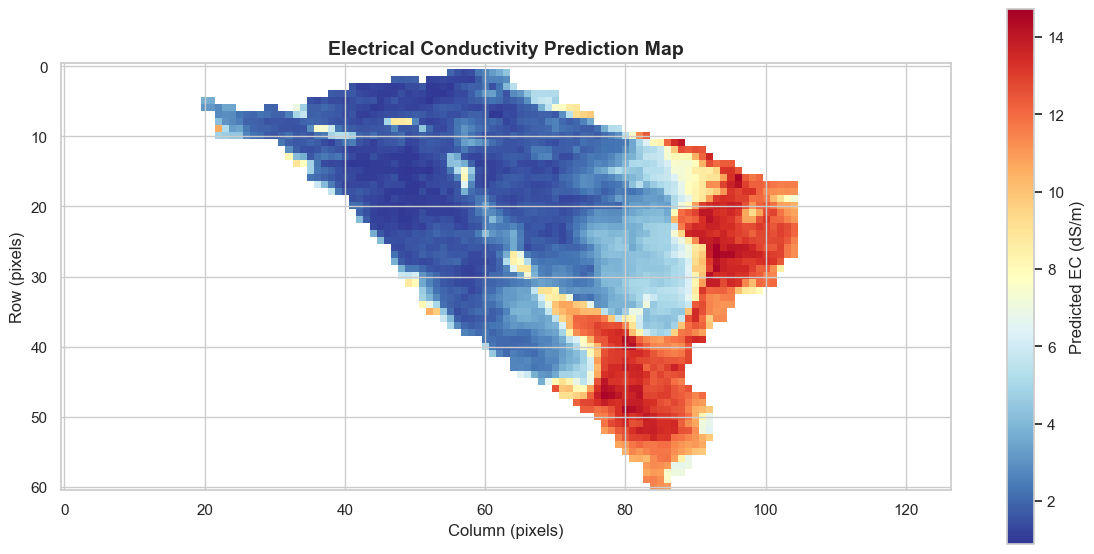

In [479]:
# ---- Visualize Prediction Map ----
plt.figure(figsize=(12, 8))

# Plot prediction map
im = plt.imshow(prediction_raster, cmap='RdYlBu_r', interpolation='nearest')
plt.colorbar(im, label='Predicted EC (dS/m)', shrink=0.7)
plt.title('Electrical Conductivity Prediction Map', fontsize=14, fontweight='bold')
plt.xlabel('Column (pixels)')
plt.ylabel('Row (pixels)')
plt.tight_layout()
plt.show()

In [480]:
# ---- Print Raster Statistics ----
# Remove NaN values for statistics calculation
valid_predictions_raster = prediction_raster[~np.isnan(prediction_raster)]
valid_predictions_raster = np.clip(valid_predictions_raster, 0, None)  # Loại bỏ giá trị âm

if len(valid_predictions_raster) > 0:
    print("=== Prediction Raster Statistics ===")
    print(f"Min EC:  {np.min(valid_predictions_raster):.4f} dS/m")
    print(f"Max EC:  {np.max(valid_predictions_raster):.4f} dS/m")
    print(f"Mean EC: {np.mean(valid_predictions_raster):.4f} dS/m")

=== Prediction Raster Statistics ===
Min EC:  0.8837 dS/m
Max EC:  14.7211 dS/m
Mean EC: 5.2966 dS/m


In [481]:
# Loại bỏ giá trị âm trước khi lưu
prediction_raster = np.clip(prediction_raster, 0, None)

output_tif = r"C:\data\DA\BT\DATA 2020\outputs\predictionRF1.tif"
with rasterio.open(
    output_tif,
    "w",
    driver="GTiff",
    height=prediction_raster.shape[0],
    width=prediction_raster.shape[1],
    count=1,
    dtype=prediction_raster.dtype,
    crs=reference_crs,
    transform=reference_transform,
    nodata=np.nan
) as dst:
    dst.write(prediction_raster, 1)

print(f"Prediction raster saved to {output_tif}")

CPLE_AppDefinedError: Deleting C:\data\DA\BT\DATA 2020\outputs\predictionRF1.tif failed: Permission denied